In [2]:
import pandas as pd
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore")
your_path = 'F:\\home-credit-default-risk'
previous_application = pd.read_csv(f'{your_path}\\previous_application.csv')
previous_application.replace(365243.0,np.nan,inplace=True)

In [3]:
numeric_features = []
categorical_features = []

for column in previous_application.columns:
    if previous_application[column].dtype == 'object':
        categorical_features.append(column)
    else:
        numeric_features.append(column)
categorical_features

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [4]:
application_train = pd.read_csv(f'{your_path}\\application_train.csv')
target_cols = application_train[['SK_ID_CURR','TARGET']]
previous_application = pd.merge(previous_application, target_cols, on='SK_ID_CURR', how='right')
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
0,1038818.0,100002.0,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9.0,...,24.0,low_normal,POS other with interest,NaN,-565.0,125.0,-25.0,-17.0,0.0,1
1,1810518.0,100003.0,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12.0,...,12.0,low_normal,Cash X-Sell: low,NaN,-716.0,-386.0,-536.0,-527.0,1.0,0
2,2636178.0,100003.0,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17.0,...,6.0,middle,POS industry with interest,NaN,-797.0,-647.0,-647.0,-639.0,0.0,0
3,2396755.0,100003.0,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15.0,...,12.0,middle,POS household with interest,NaN,-2310.0,-1980.0,-1980.0,-1976.0,1.0,0
4,1564014.0,100004.0,Consumer loans,5357.250,24282.0,20106.0,4860.0,24282.0,FRIDAY,5.0,...,4.0,middle,POS mobile without interest,NaN,-784.0,-694.0,-724.0,-714.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430150,2073384.0,456255.0,Cash loans,16400.610,229500.0,254340.0,NaN,229500.0,THURSDAY,12.0,...,24.0,middle,Cash X-Sell: middle,NaN,-618.0,72.0,-558.0,-528.0,1.0,0
1430151,1708056.0,456255.0,Revolving loans,2250.000,45000.0,45000.0,NaN,45000.0,SUNDAY,14.0,...,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN,0
1430152,1296007.0,456255.0,Cash loans,30737.655,765000.0,1067940.0,NaN,765000.0,FRIDAY,14.0,...,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN,0
1430153,2631384.0,456255.0,Cash loans,54022.140,1170000.0,1271929.5,NaN,1170000.0,FRIDAY,14.0,...,36.0,low_normal,Cash X-Sell: low,NaN,-756.0,294.0,-66.0,-64.0,0.0,0


In [5]:
def calculate_woe_iv(df, feature, target):
    df_cross = pd.crosstab(df[feature], df[target])
    df_cross['Total'] = df_cross.sum(axis=1)
    df_cross['Event Rate'] = df_cross[1] / df_cross['Total']
    df_cross['Non-Event Rate'] = df_cross[0] / df_cross['Total']

    df_cross['Event Distribution'] = df_cross[1] / df_cross[1].sum()
    df_cross['Non-Event Distribution'] = df_cross[0] / df_cross[0].sum()
    df_cross['WoE'] = np.log((df_cross['Event Distribution'] + 0.0001) / (df_cross['Non-Event Distribution'] + 0.0001))

    df_cross['IV'] = (df_cross['Event Distribution'] - df_cross['Non-Event Distribution']) * df_cross['WoE']

    iv = df_cross['IV'].sum()
    return iv

iv_values = {col: calculate_woe_iv(previous_application, col, 'TARGET') for col in categorical_features}

iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'Information Value'])
iv_df = iv_df.sort_values(by='Information Value', ascending=False)
iv_df

,Feature,Information Value
15,PRODUCT_COMBINATION,0.041734
6,CODE_REJECT_REASON,0.040237
4,NAME_CONTRACT_STATUS,0.039577
14,NAME_YIELD_GROUP,0.023501
11,NAME_PRODUCT_TYPE,0.020207
9,NAME_GOODS_CATEGORY,0.018933
13,NAME_SELLER_INDUSTRY,0.018146
12,CHANNEL_TYPE,0.016664
10,NAME_PORTFOLIO,0.014434
0,NAME_CONTRACT_TYPE,0.013929


In [6]:
def calculate_woe_iv(df, feature, target):
    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 0)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    return dset

for column in previous_application.select_dtypes(include='object').columns:
    if column != 'TARGET':
        woe_df = calculate_woe_iv(previous_application, column, 'TARGET')
        previous_application = previous_application.merge(woe_df[['Value', 'WoE']], left_on=column, right_on='Value', how='left')
        previous_application.drop(columns=[column, 'Value'], inplace=True)
        previous_application.rename(columns={'WoE': 'woe_' + column}, inplace=True)
previous_application

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,woe_CODE_REJECT_REASON,woe_NAME_TYPE_SUITE,woe_NAME_CLIENT_TYPE,woe_NAME_GOODS_CATEGORY,woe_NAME_PORTFOLIO,woe_NAME_PRODUCT_TYPE,woe_CHANNEL_TYPE,woe_NAME_SELLER_INDUSTRY,woe_NAME_YIELD_GROUP,woe_PRODUCT_COMBINATION
0,1038818.0,100002.0,9251.775,179055.0,179055.0,0.0,179055.0,9.0,1.0,0.000000,...,0.093156,NaN,-0.042193,-0.165456,0.136506,0.038614,0.174891,-0.199239,0.210104,0.067717
1,1810518.0,100003.0,98356.995,900000.0,1035882.0,NaN,900000.0,12.0,1.0,NaN,...,0.093156,-0.036645,-0.007479,-0.089048,-0.027554,0.074005,-0.044053,-0.085285,0.210104,0.296025
2,2636178.0,100003.0,64567.665,337500.0,348637.5,0.0,337500.0,17.0,1.0,0.000000,...,0.093156,0.075067,0.179671,0.422053,0.136506,0.038614,0.174891,0.374802,0.080026,0.342626
3,2396755.0,100003.0,6737.310,68809.5,68053.5,6885.0,68809.5,15.0,1.0,0.100061,...,0.093156,0.075067,0.179671,0.219998,0.136506,0.038614,0.051720,0.148370,0.080026,0.122452
4,1564014.0,100004.0,5357.250,24282.0,20106.0,4860.0,24282.0,5.0,1.0,0.212008,...,0.093156,-0.036645,-0.042193,0.001043,0.136506,0.038614,0.140848,-0.067657,0.080026,0.101783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430150,2073384.0,456255.0,16400.610,229500.0,254340.0,NaN,229500.0,12.0,1.0,NaN,...,0.093156,NaN,-0.007479,-0.089048,-0.027554,0.074005,-0.044053,-0.085285,0.080026,0.108325
1430151,1708056.0,456255.0,2250.000,45000.0,45000.0,NaN,45000.0,14.0,1.0,NaN,...,-0.338475,-0.036645,-0.007479,-0.089048,-0.176999,-0.407721,0.051720,-0.067657,-0.143959,-0.295099
1430152,1296007.0,456255.0,30737.655,765000.0,1067940.0,NaN,765000.0,14.0,1.0,NaN,...,-0.338475,-0.036645,-0.007479,-0.089048,-0.027554,-0.407721,-0.044053,-0.085285,0.210104,-0.170397
1430153,2631384.0,456255.0,54022.140,1170000.0,1271929.5,NaN,1170000.0,14.0,1.0,NaN,...,0.093156,-0.036645,-0.007479,-0.089048,-0.027554,0.074005,-0.439951,-0.085285,0.210104,0.296025


In [7]:
import pandas as pd


target_data = previous_application[['SK_ID_CURR', 'TARGET']]
df_without_target = previous_application.drop(columns=['TARGET','SK_ID_PREV'])
aggregations = {col: ['max', 'min', 'mean', 'std','sum','count'] for col in df_without_target.columns if col != 'SK_ID_CURR'}
result_df = df_without_target.groupby('SK_ID_CURR').agg(aggregations)
result_df.columns = ['{}_{}'.format(col_name, agg_func) for col_name, agg_list in aggregations.items() for agg_func in agg_list]
target_data = target_data.drop_duplicates()
final_df = result_df.merge(target_data, on='SK_ID_CURR', how='right')
final_df

,SK_ID_CURR,AMT_ANNUITY_max,AMT_ANNUITY_min,AMT_ANNUITY_mean,AMT_ANNUITY_std,AMT_ANNUITY_sum,AMT_ANNUITY_count,AMT_APPLICATION_max,AMT_APPLICATION_min,AMT_APPLICATION_mean,...,woe_NAME_YIELD_GROUP_std,woe_NAME_YIELD_GROUP_sum,woe_NAME_YIELD_GROUP_count,woe_PRODUCT_COMBINATION_max,woe_PRODUCT_COMBINATION_min,woe_PRODUCT_COMBINATION_mean,woe_PRODUCT_COMBINATION_std,woe_PRODUCT_COMBINATION_sum,woe_PRODUCT_COMBINATION_count,TARGET
0,100002.0,9251.775,9251.775,9251.775000,NaN,9251.775,1,179055.0,179055.0,179055.000,...,NaN,0.210104,1,0.067717,0.067717,0.067717,NaN,0.067717,1,1
1,100003.0,98356.995,6737.310,56553.990000,46332.557777,169661.970,3,900000.0,68809.5,435436.500,...,0.075100,0.370157,3,0.342626,0.122452,0.253701,0.116028,0.761103,3,0
2,100004.0,5357.250,5357.250,5357.250000,NaN,5357.250,1,24282.0,24282.0,24282.000,...,NaN,0.080026,1,0.101783,0.101783,0.101783,NaN,0.101783,1,0
3,100006.0,39954.510,2482.920,23651.175000,13623.580119,141907.050,6,688500.0,0.0,272203.260,...,0.154663,-0.290912,9,0.342626,-0.315238,0.016982,0.255153,0.152840,9,0
4,100007.0,22678.785,1834.290,12278.805000,8063.586466,73672.830,6,247500.0,17176.5,150530.250,...,0.102797,-0.082885,6,0.122452,-0.302416,0.020912,0.166980,0.125473,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,6605.910,6605.910,6605.910000,NaN,6605.910,1,40455.0,40455.0,40455.000,...,NaN,-0.107655,1,-0.019539,-0.019539,-0.019539,NaN,-0.019539,1,0
307507,456252.0,10074.465,10074.465,10074.465000,NaN,10074.465,1,57595.5,57595.5,57595.500,...,NaN,0.210104,1,0.286802,0.286802,0.286802,NaN,0.286802,1,0
307508,456253.0,5567.715,3973.095,4770.405000,1127.566615,9540.810,2,28912.5,19413.0,24162.750,...,0.000000,-0.215310,2,-0.019539,-0.019539,-0.019539,0.000000,-0.039078,2,0
307509,456254.0,19065.825,2296.440,10681.132500,11857.745850,21362.265,2,223789.5,18846.0,121317.750,...,0.224690,0.102449,2,0.122452,-0.019539,0.051457,0.100403,0.102914,2,1


        SK_ID_CURR  AMT_ANNUITY_max  AMT_ANNUITY_min  AMT_ANNUITY_mean  \
0         100002.0         9251.775         9251.775       9251.775000   
1         100003.0        98356.995         6737.310      56553.990000   
2         100004.0         5357.250         5357.250       5357.250000   
3         100006.0        39954.510         2482.920      23651.175000   
4         100007.0        22678.785         1834.290      12278.805000   
...            ...              ...              ...               ...   
307506    456251.0         6605.910         6605.910       6605.910000   
307507    456252.0        10074.465        10074.465      10074.465000   
307508    456253.0         5567.715         3973.095       4770.405000   
307509    456254.0        19065.825         2296.440      10681.132500   
307510    456255.0        54022.140         2250.000      20775.391875   

        AMT_ANNUITY_std  AMT_ANNUITY_sum  AMT_ANNUITY_count  \
0                   NaN         9251.775        

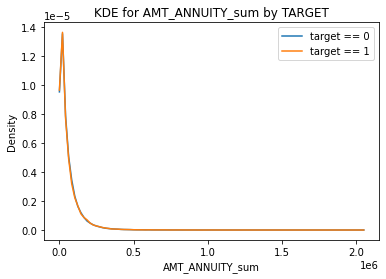

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


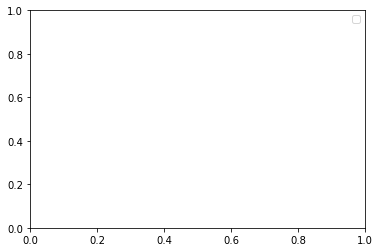

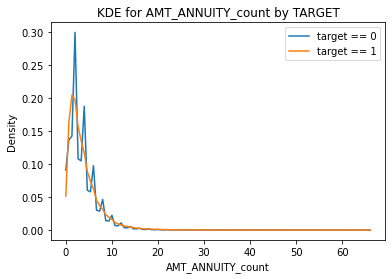

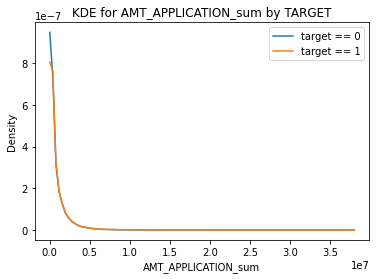

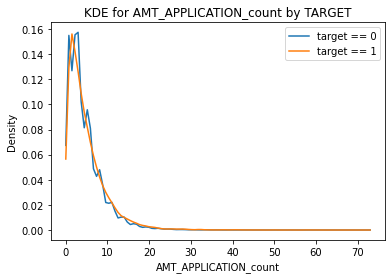

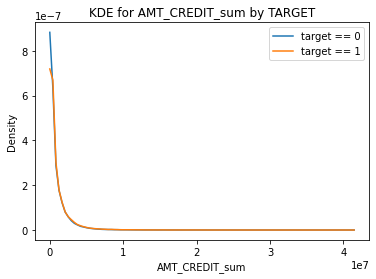

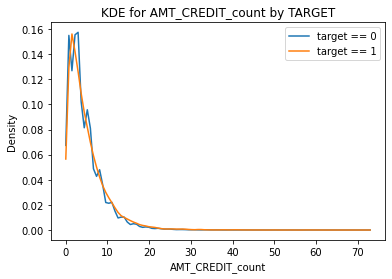

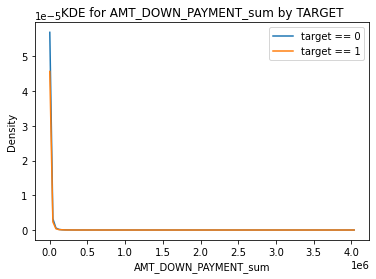

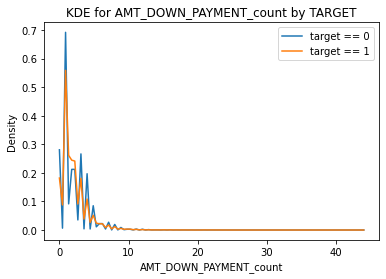

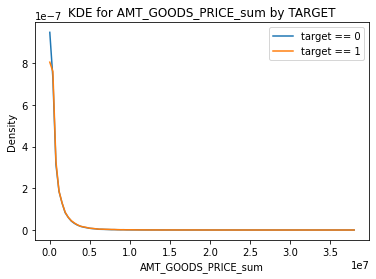

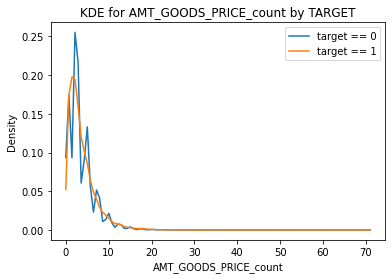

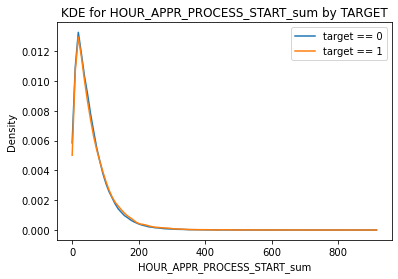

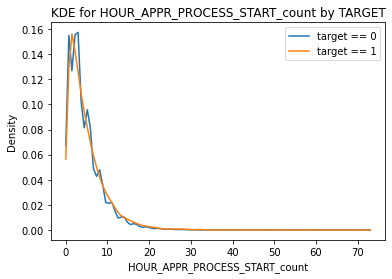

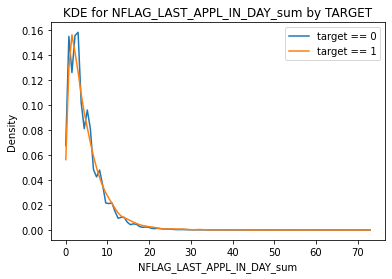

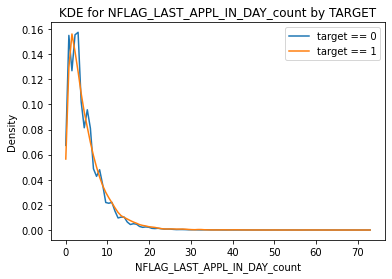

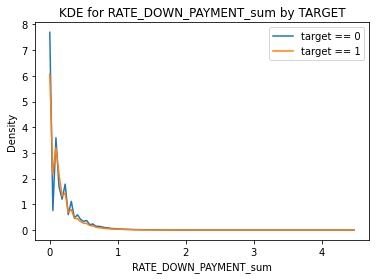

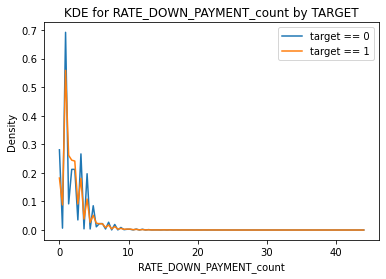

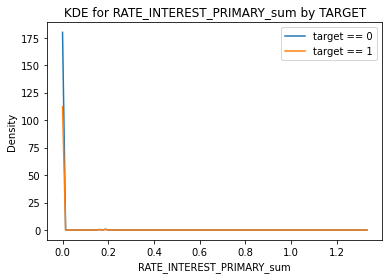

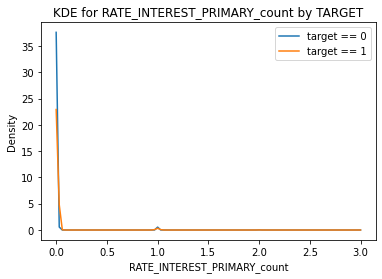

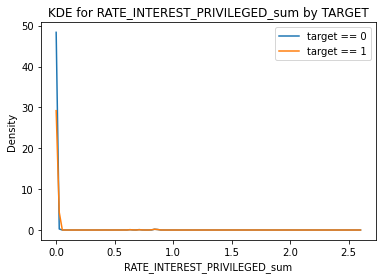

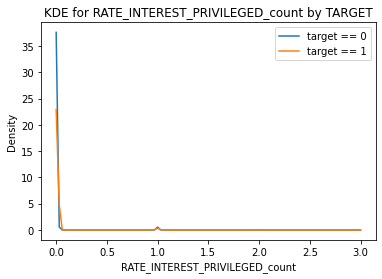

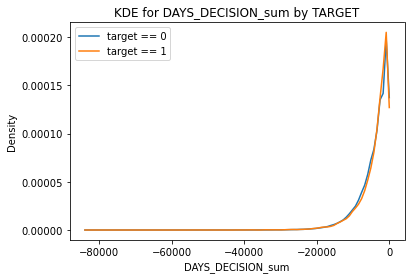

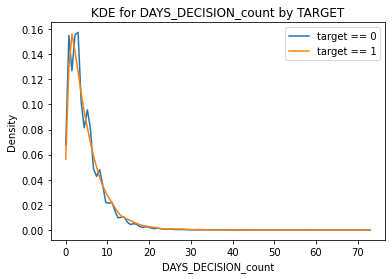

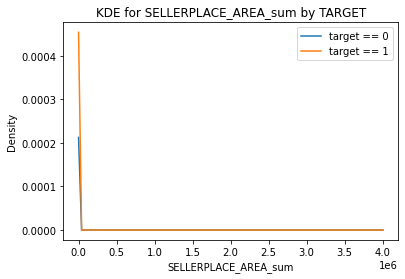

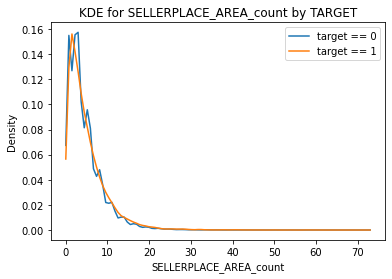

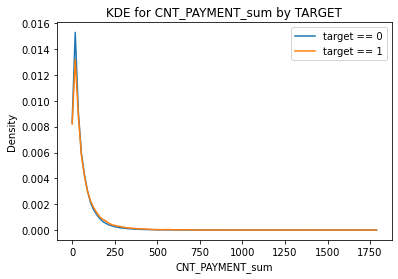

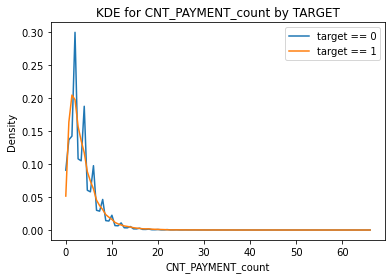

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


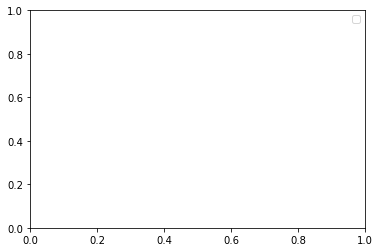

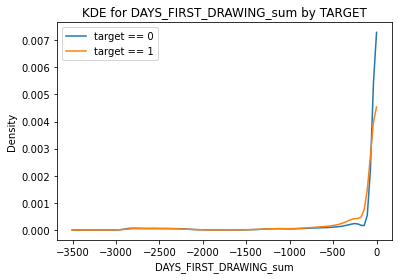

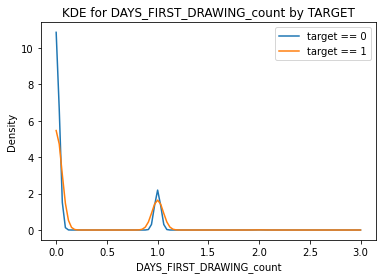

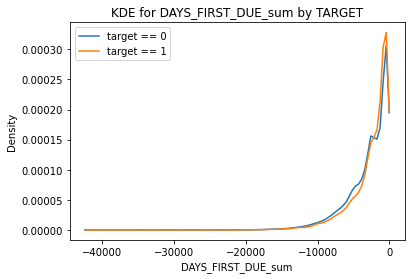

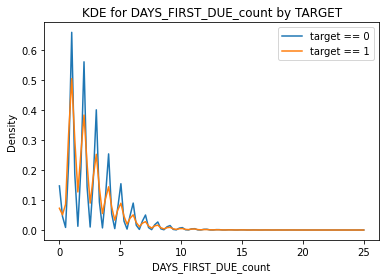

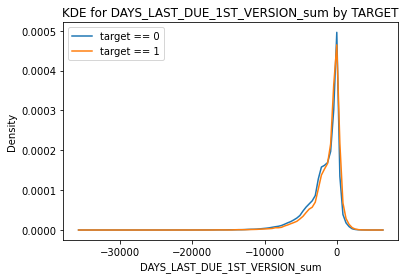

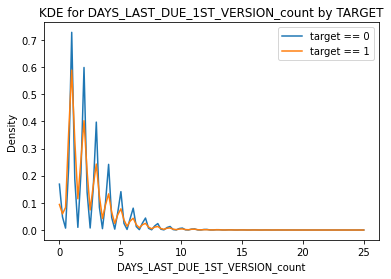

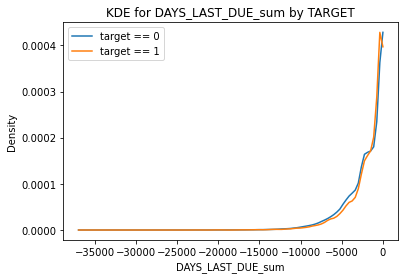

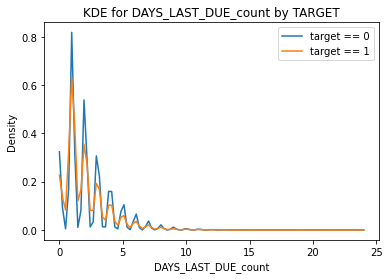

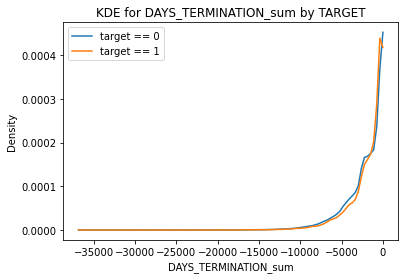

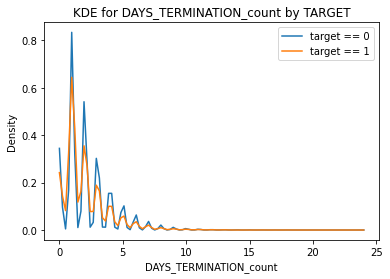

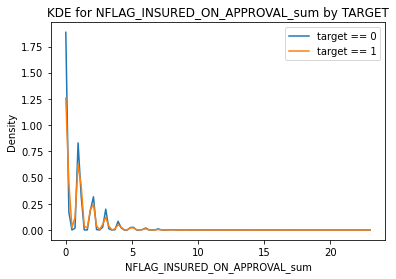

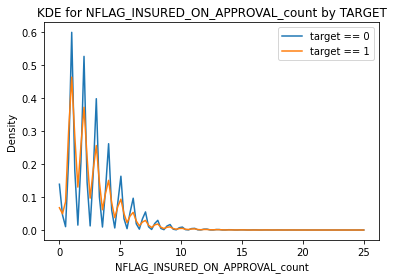

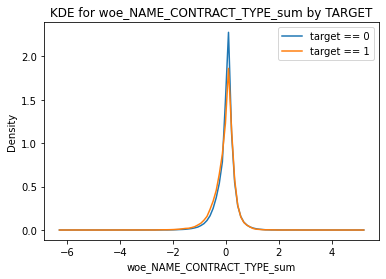

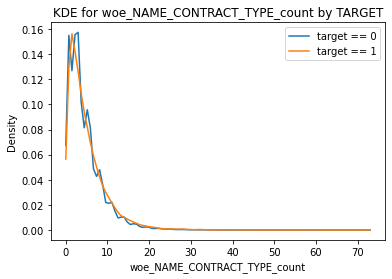

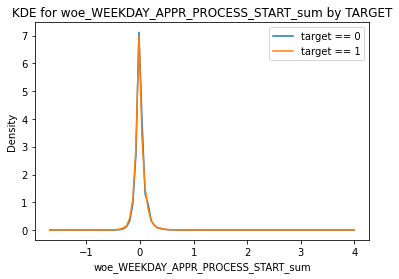

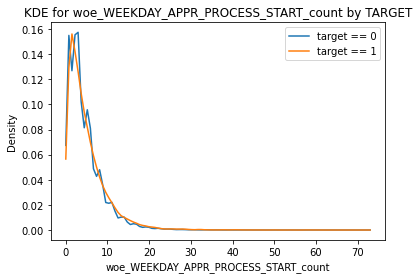

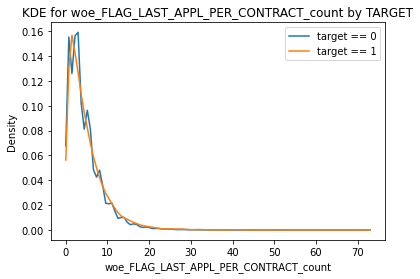

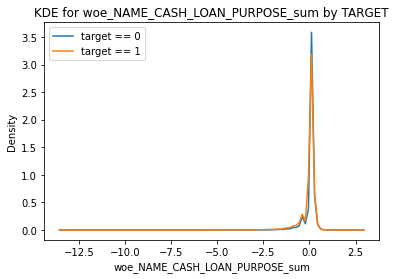

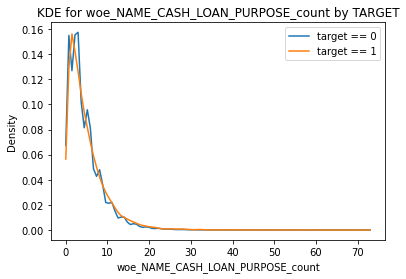

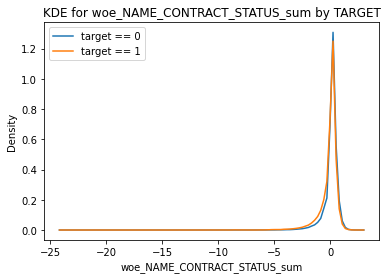

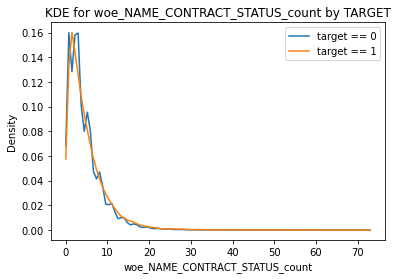

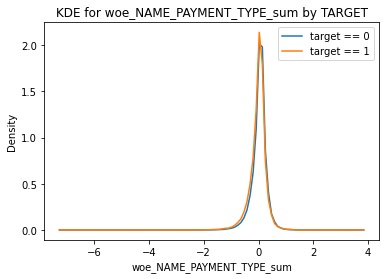

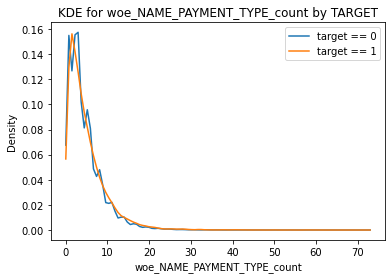

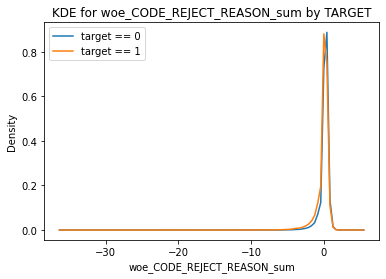

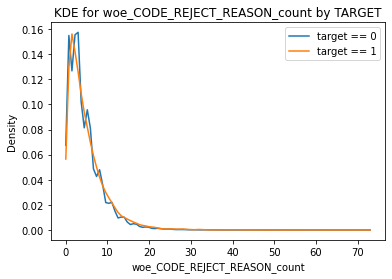

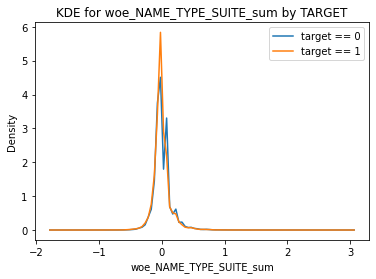

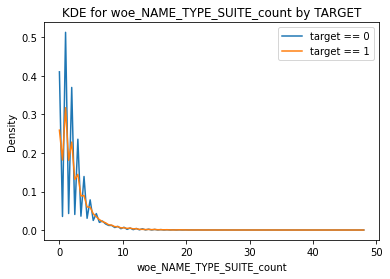

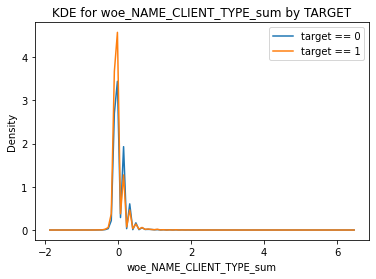

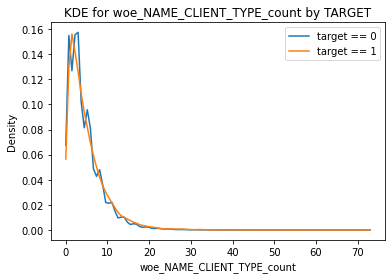

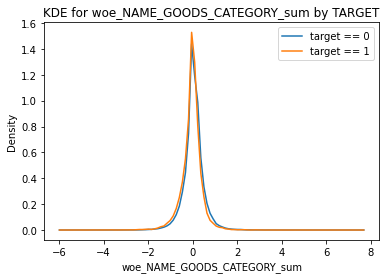

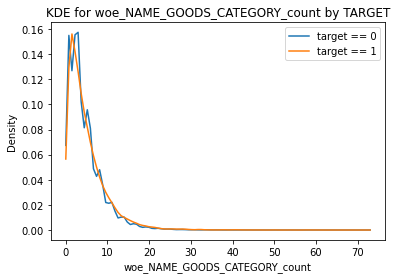

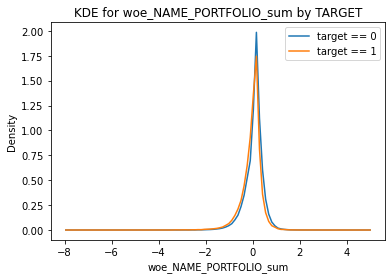

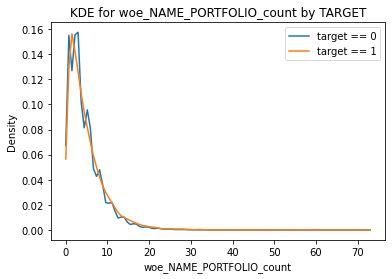

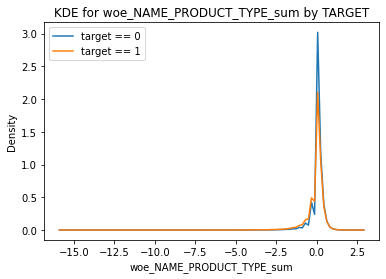

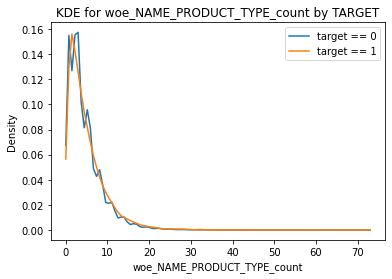

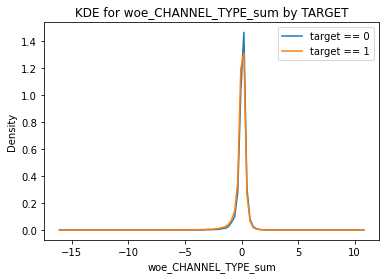

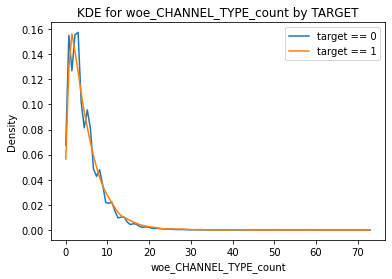

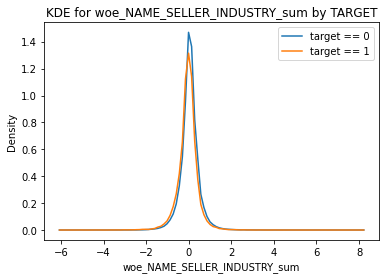

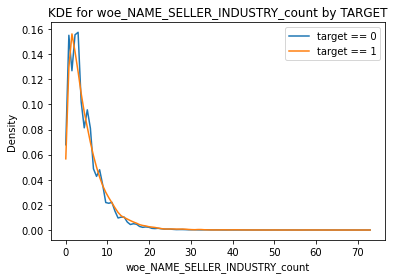

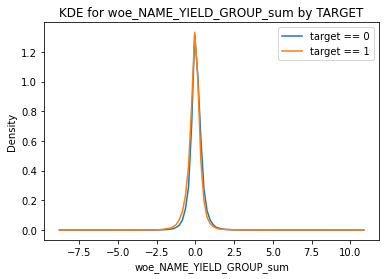

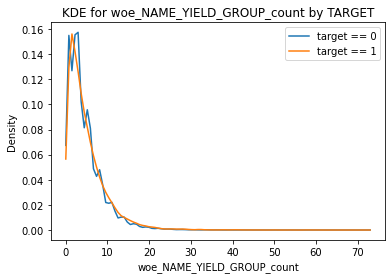

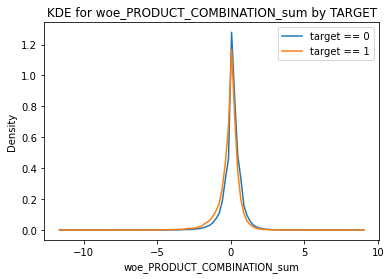

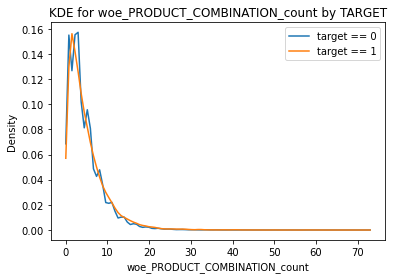

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

final_df_clean = final_df
print(final_df_clean)
for i, feature in enumerate(final_df_clean.columns[1:]):
    try:
        data_0 = final_df_clean[final_df_clean['TARGET'] == 0][feature]
        data_1 = final_df_clean[final_df_clean['TARGET'] == 1][feature]
        kde_0 = gaussian_kde(data_0)
        kde_1 = gaussian_kde(data_1)
        x_range = np.linspace(min(data_0.min(), data_1.min()), max(data_0.max(), data_1.max()), 100)

        plt.plot(x_range, kde_0(x_range), label='target == 0')
        plt.plot(x_range, kde_1(x_range), label='target == 1')

        plt.title(f'KDE for {feature} by TARGET')
        plt.xlabel(feature)
        plt.ylabel('Density')
        if feature == 'CNT_PAYMENT_count' or feature == 'AMT_ANNUITY_sum':
            plt.legend()
            plt.savefig('{}.png'.format(feature),dpi=500)
            plt.show()
        

        plt.legend()
        plt.show()
    except:
        pass


In [41]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

X = final_df.drop(['TARGET','SK_ID_CURR'], axis=1)  
y = final_df['TARGET']  

params = {
    'scale_pos_weight':15,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 100,
    "learning_rate": 0.05,
    "max_bin": 255,
    "n_estimators": 300,
    "colsample_bytree": 0.9, 
    "colsample_bynode": 0.9,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1, 
    "reg_lambda": 3.25, 
    "extra_trees":True,
    "device": "gpu",
}

model = lgb.LGBMClassifier(**params)
scoring = ['precision', 'recall']

model.fit(X, y)
cv_result= cross_validate(model, X, y, cv=5, scoring=scoring)



In [47]:
print(cv_result)

{'fit_time': array([23.19503307, 23.25989175, 23.03660607, 22.45647645, 22.38233399]), 'score_time': array([0.42662215, 0.44810677, 0.43410277, 0.4210937 , 0.41209102]), 'test_precision': array([0.11576891, 0.11669205, 0.11440486, 0.11346055, 0.11640365]), 'test_recall': array([0.72809668, 0.72527694, 0.71278953, 0.70896274, 0.7264854 ])}


In [46]:
pd.DataFrame(importance_df.iloc[0:50])

,Feature,Importance
74,CNT_PAYMENT_mean,407
90,DAYS_LAST_DUE_1ST_VERSION_max,356
96,DAYS_LAST_DUE_max,258
75,CNT_PAYMENT_std,249
2,AMT_ANNUITY_mean,242
78,DAYS_FIRST_DRAWING_max,228
25,AMT_GOODS_PRICE_min,226
80,DAYS_FIRST_DRAWING_mean,223
87,DAYS_FIRST_DUE_std,222
79,DAYS_FIRST_DRAWING_min,220


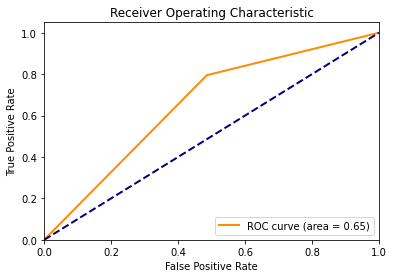

In [43]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_proba = model.predict(X)
fpr, tpr, _ = roc_curve(y, y_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [2]:
selected_features = list(pd.DataFrame(importance_df.iloc[0:50])['Feature'])
selected_features.append('SK_ID_CURR')
final_df[selected_features]

NameError: name 'pd' is not defined

In [12]:
final_df.drop(['TARGET'],inplace=True,axis=1)
final_df.to_csv('E://result//previous_application.csv',index=False)

In [13]:
final_df

,SK_ID_CURR,AMT_ANNUITY_max,AMT_ANNUITY_min,AMT_ANNUITY_mean,AMT_ANNUITY_std,AMT_ANNUITY_sum,AMT_ANNUITY_count,AMT_APPLICATION_max,AMT_APPLICATION_min,AMT_APPLICATION_mean,...,woe_NAME_YIELD_GROUP_mean,woe_NAME_YIELD_GROUP_std,woe_NAME_YIELD_GROUP_sum,woe_NAME_YIELD_GROUP_count,woe_PRODUCT_COMBINATION_max,woe_PRODUCT_COMBINATION_min,woe_PRODUCT_COMBINATION_mean,woe_PRODUCT_COMBINATION_std,woe_PRODUCT_COMBINATION_sum,woe_PRODUCT_COMBINATION_count
0,100002.0,9251.775,9251.775,9251.775000,NaN,9251.775,1,179055.0,179055.0,179055.000,...,0.210104,NaN,0.210104,1,0.067717,0.067717,0.067717,NaN,0.067717,1
1,100003.0,98356.995,6737.310,56553.990000,46332.557777,169661.970,3,900000.0,68809.5,435436.500,...,0.123386,0.075100,0.370157,3,0.342626,0.122452,0.253701,0.116028,0.761103,3
2,100004.0,5357.250,5357.250,5357.250000,NaN,5357.250,1,24282.0,24282.0,24282.000,...,0.080026,NaN,0.080026,1,0.101783,0.101783,0.101783,NaN,0.101783,1
3,100006.0,39954.510,2482.920,23651.175000,13623.580119,141907.050,6,688500.0,0.0,272203.260,...,-0.032324,0.154663,-0.290912,9,0.342626,-0.315238,0.016982,0.255153,0.152840,9
4,100007.0,22678.785,1834.290,12278.805000,8063.586466,73672.830,6,247500.0,17176.5,150530.250,...,-0.013814,0.102797,-0.082885,6,0.122452,-0.302416,0.020912,0.166980,0.125473,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,6605.910,6605.910,6605.910000,NaN,6605.910,1,40455.0,40455.0,40455.000,...,-0.107655,NaN,-0.107655,1,-0.019539,-0.019539,-0.019539,NaN,-0.019539,1
307507,456252.0,10074.465,10074.465,10074.465000,NaN,10074.465,1,57595.5,57595.5,57595.500,...,0.210104,NaN,0.210104,1,0.286802,0.286802,0.286802,NaN,0.286802,1
307508,456253.0,5567.715,3973.095,4770.405000,1127.566615,9540.810,2,28912.5,19413.0,24162.750,...,-0.107655,0.000000,-0.215310,2,-0.019539,-0.019539,-0.019539,0.000000,-0.039078,2
307509,456254.0,19065.825,2296.440,10681.132500,11857.745850,21362.265,2,223789.5,18846.0,121317.750,...,0.051225,0.224690,0.102449,2,0.122452,-0.019539,0.051457,0.100403,0.102914,2
